In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # import statsmodels 
import pickle

## Load data

In [37]:
################################### Read Data ##########################################
'''
DT_min = 15 # dwell time
data = pd.read_csv('trip_v1.csv')  # read data
data = data.sort_values(by=['HOUSEID'])  # sort by house ID
data = data.drop(data[data.VMT_MILE == -1].index)  # only keeps personally driven vehicle trips.
# data = data.drop(data[data.WHYTO != 1].index)  # trip des =1 : home
data = data.drop(data[data.WHYTRP1S == 1].index)  # trip des =1 : home

data = data.drop(data[data.TRPTRANS ==-7].index)  # veh type
data = data.drop(data[data.TRPTRANS ==-8].index)  
data = data.drop(data[data.TRPTRANS ==1].index)  
data = data.drop(data[data.TRPTRANS ==2].index)  
data = data.drop(data[data.TRPTRANS ==7].index)
data = data.drop(data[data.TRPTRANS ==97].index)  

# data = data.drop(data[data.DWELTIME < DT_min].index)  # dwell time positive (longger than 5)
data = data.drop(data[data.VMT_MILE > 1600].index)  # daily max range = 1600 mile = 60*24
data = data.drop(data[data.DWELTIME < 0].index)  # dwell time positive (longger than 5)

data.reset_index(inplace = True, drop = True) # reset index and replace orignal index

data.to_pickle('trip_v4.pkl') 

vehicle = pd.read_csv('vehpub.csv')  # read data

'''
data = pd.read_pickle('trip_v4.pkl')
data = data[data.DWELTIME > 15] # dwell time

data

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,VEHID,WHYFROM,TRIPPURP,DWELTIME,TDWKND,VMT_MILE,DRVR_FLG,WHYTRP1S,WHYTO,TRAVDAY,WTTRDFIN,TRPTRANS
0,30000007,1,1,1000,1015,15,5.244,3,1,HBO,295,2,5.244,1,20,19,2,75441.90580,3
1,30000007,3,1,845,900,15,2.250,1,1,HBO,330,2,2.250,1,20,8,2,80122.68674,3
2,30000008,1,1,1115,1130,15,8.017,4,1,HBW,720,2,8.017,1,10,3,5,23062.85743,6
3,30000012,1,8,1715,1850,95,48.301,1,1,HBSOCREC,125,2,48.301,1,50,17,5,21522.69051,3
4,30000012,1,6,1415,1440,25,9.087,1,4,NHB,50,2,9.087,1,10,3,5,21522.69051,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397803,40794301,3,2,1658,1705,7,0.781,3,6,NHB,53,2,0.781,1,40,11,2,77932.84989,5
397804,40794301,2,1,800,830,30,11.362,4,1,HBW,150,2,11.362,1,10,3,2,49408.74064,6
397805,40794301,2,4,1630,1646,16,6.728,4,3,NHB,36,2,6.728,1,40,11,2,49408.74064,6
397806,40794301,2,3,1138,1150,12,2.910,4,13,NHB,280,2,2.910,1,10,3,2,49408.74064,6


## Scenario 1: charge during dwell time

(0.0, 15000.0)

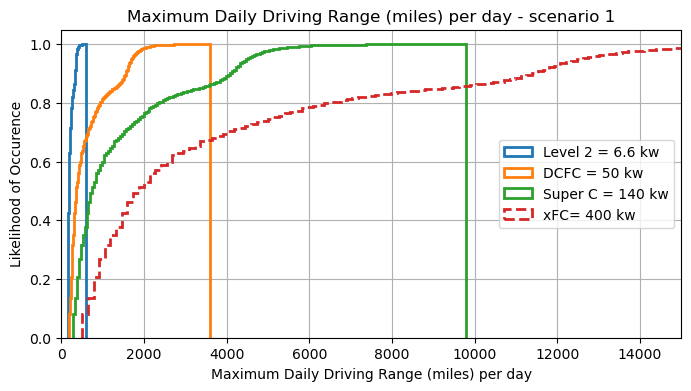

In [30]:
Power1 = 6.6 # KW
Power2 = 50
Power3 = 140
Power4 = 400

AER_all = [150,200,300,400] # mile
AER = AER_all[0]

eu = [0.3, 0.305, 0.307, 0.329, 0.38, 0.385] # electric use kwh/mile
efficency = eu[0] # kwh/mile

Chrg_capacity = 45 # kwh

res = data
res['DIST_Power1'] = res['DWELTIME']/60 * Power1 / efficency + AER
res['DIST_Power2'] = res['DWELTIME']/60 * Power2 / efficency + AER
res['DIST_Power3'] = res['DWELTIME']/60 * Power3 / efficency + AER
res['DIST_Power4'] = res['DWELTIME']/60 * Power4 / efficency + AER

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(res['DIST_Power1'], 200, lw=2,density=True, histtype='step', cumulative=True, label='Level 2 = 6.6 kw')
ax.hist(res['DIST_Power2'], 200, lw=2,density=True, histtype='step', cumulative=True, label='DCFC = 50 kw')
ax.hist(res['DIST_Power3'], 200, lw=2,density=True, histtype='step', cumulative=True,label='Super C = 140 kw')
ax.hist(res['DIST_Power4'], 200, lw=2,density=True, histtype='step', cumulative=True, linestyle=('dashed'), label='xFC= 400 kw')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range (miles) per day - scenario 1')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 15000))

Text(0.5, 1.0, 'Percentage of BEV Feasible Trips - Scenario 1')

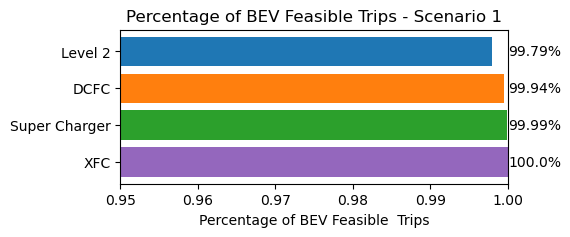

In [31]:
mile_left = 10
res['feasible1'] = (res['DIST_Power1']>=res['VMT_MILE']+ mile_left)
res['feasible2'] = (res['DIST_Power2']>=res['VMT_MILE']+ mile_left)
res['feasible3'] = (res['DIST_Power3']>=res['VMT_MILE']+ mile_left)
res['feasible4'] = (res['DIST_Power4']>=res['VMT_MILE']+ mile_left)

p = []
p.append(sum(res['feasible1'])/len(res['feasible1']))
p.append(sum(res['feasible2'])/len(res['feasible2']))
p.append(sum(res['feasible3'])/len(res['feasible3']))
p.append(sum(res['feasible4'])/len(res['feasible4']))

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (5,2))
label = ['Level 2','DCFC','Super Charger','XFC']
y_pos = np.arange(len(label))
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.barh(y_pos, p, align='center',color = ['#1f77b4','#ff7f0e','#2ca02c','#9467bd'])
                                          
for group in range(0,len(p)):
    ax.text(1, group, str(round(p[group]*100,2))+'%', fontsize=10, verticalalignment="center")
   
ax.set_xlabel('Percentage of BEV Feasible  Trips')
plt.xlim((0.95, 1))
ax.set_title('Percentage of BEV Feasible Trips - Scenario 1')

## scenario 2: Trip-based, constrained by the distance travelled

In [32]:
htemp = data['HOUSEID'][0] # each unique houseID
ptemp = data['PERSONID'][0]

AER = 150
miles_temp = 0 # total miles
dw_temp = 0 # dwell time
tt_temp = 0 # travel time
dist_temp1 = AER
dist_temp2 = AER
dist_temp3 = AER
dist_temp4 = AER

Chrg_capacity = AER * efficency # kwh

res = pd.DataFrame(columns = ['H_ID', 'P_ID','MILES','TIMES','DWT','Weight','DIST2_Power1','DIST2_Power2','DIST2_Power3','DIST2_Power4']) 
for n in range(len(data)):
    
    if data['HOUSEID'][n] == htemp and data['PERSONID'][n] == ptemp: # same household ID, same persion ID
        
        miles_temp += data['VMT_MILE'][n]
        dw_temp += data['DWELTIME'][n]
        tt_temp += data['TRVLCMIN'][n]
        
        dist_temp1 += min(data['DWELTIME'][n]/60 * Power1, Chrg_capacity) / efficency
        dist_temp2 += min(data['DWELTIME'][n]/60 * Power2, Chrg_capacity) / efficency
        dist_temp3 += min(data['DWELTIME'][n]/60 * Power3, Chrg_capacity) / efficency
        dist_temp4 += min(data['DWELTIME'][n]/60 * Power4, Chrg_capacity) / efficency

        
    elif data['HOUSEID'][n] == htemp and data['PERSONID'][n] != ptemp: # Same HH id, diff persion ID
        
        res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'TIMES': tt_temp, 'DWT': dw_temp,'Weight':data['WTTRDFIN'][n],'DIST2_Power1': dist_temp1, 'DIST2_Power2': dist_temp2, 'DIST2_Power3': dist_temp3, 'DIST2_Power4': dist_temp4}, ignore_index=True) 
        
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]
        dw_temp = data['DWELTIME'][n] 
        tt_temp = data['TRVLCMIN'][n]
        
        dist_temp1 = min(data['DWELTIME'][n]/60 * Power1, Chrg_capacity) / efficency + AER
        dist_temp2 = min(data['DWELTIME'][n]/60 * Power2, Chrg_capacity) / efficency + AER
        dist_temp3 = min(data['DWELTIME'][n]/60 * Power3, Chrg_capacity) / efficency + AER
        dist_temp4 = min(data['DWELTIME'][n]/60 * Power4, Chrg_capacity) / efficency + AER

        
    elif data['HOUSEID'][n] != htemp: # diff HH ID
        
        res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'TIMES': tt_temp, 'DWT': dw_temp,'Weight':data['WTTRDFIN'][n],'DIST2_Power1': dist_temp1, 'DIST2_Power2': dist_temp2, 'DIST2_Power3': dist_temp3, 'DIST2_Power4': dist_temp4}, ignore_index=True) 
        
        htemp = data['HOUSEID'][n]
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]
        dw_temp = data['DWELTIME'][n]
        tt_temp = data['TRVLCMIN'][n]

        dist_temp1 = min(data['DWELTIME'][n]/60 * Power1, Chrg_capacity) / efficency + AER
        dist_temp2 = min(data['DWELTIME'][n]/60 * Power2, Chrg_capacity) / efficency + AER
        dist_temp3 = min(data['DWELTIME'][n]/60 * Power3, Chrg_capacity) / efficency + AER
        dist_temp4 = min(data['DWELTIME'][n]/60 * Power4, Chrg_capacity) / efficency + AER

# res.to_pickle('results_feasibility/res_scenario2.pkl')  
# res = pd.read_pickle('results_feasibility/res_scenario2.pkl')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(res['DIST2_Power1'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Level 2 = 6.6 kw')
ax.hist(res['DIST2_Power2'], 100, lw =2, density=True, histtype='step', cumulative=True, label='DCFC = 50 kw')
ax.hist(res['DIST2_Power3'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Super C = 140 kw')
ax.hist(res['DIST2_Power4'], 100, lw =2, density=True, histtype='step',linestyle=('dashed'), cumulative=True, label='xFC = 400 kw')
# plt.axhline(y=0.9,xmin = 0, xmax = 0.2, color='k', linestyle='--')
# plt.axvline(x = 320, ymin=0, ymax = 0.9,color='k', linestyle='--')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range (miles) per day - scenario 2')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')


KeyError: 15

Text(0.5, 1.0, 'Percentage of BEV Feasible Trips - Scenario 2')

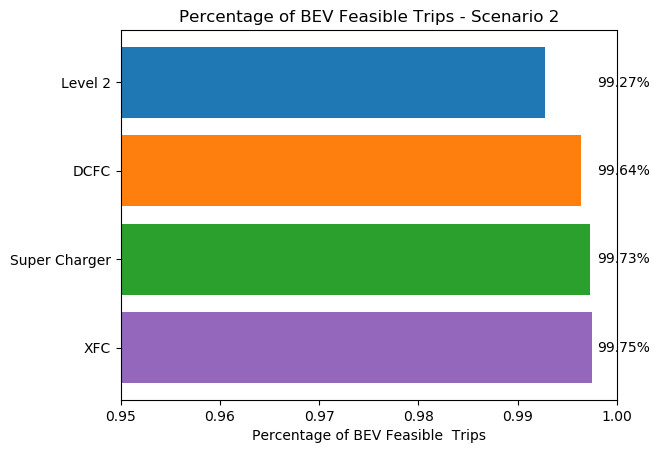

In [17]:
mile_left = 10
res['feasible1'] = (res['DIST2_Power1']>=res['MILES'] + mile_left)
res['feasible2'] = (res['DIST2_Power2']>=res['MILES'] + mile_left)
res['feasible3'] = (res['DIST2_Power3']>=res['MILES'] + mile_left)
res['feasible4'] = (res['DIST2_Power4']>=res['MILES'] + mile_left)

p = []
p.append(sum(res['feasible1'])/len(res['feasible1']))
p.append(sum(res['feasible2'])/len(res['feasible2']))
p.append(sum(res['feasible3'])/len(res['feasible3']))
p.append(sum(res['feasible4'])/len(res['feasible4']))

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (5,2))
label = ['Level 2','DCFC','Super Charger','XFC']
y_pos = np.arange(len(label))
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.barh(y_pos, p, align='center',color = ['#1f77b4','#ff7f0e','#2ca02c','#9467bd'])
ax.set_xlabel('Percentage of BEV Feasible  Trips')
plt.xlim((0.95, 1))
                                          
for group in range(0,len(p)):
    ax.text(0.998, group, str(round(p[group]*100,2))+'%', fontsize=10, verticalalignment="center")

ax.set_title('Percentage of BEV Feasible Trips - Scenario 2')

## scenario 3: charge during dwell time, constrained by the battery capacity and trips 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'Likelihood of Occurence')

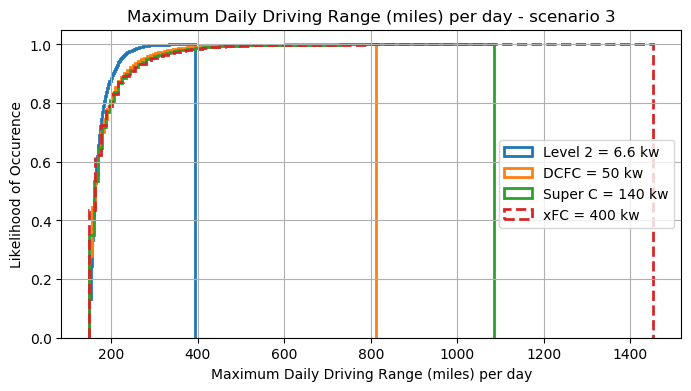

In [53]:
htemp = data['HOUSEID'][0] # each unique houseID
ptemp = data['PERSONID'][0]

data.VMT_MILE[data.VMT_MILE < 0] = 0 # total miles traveled negative or less than 5 => 0

AER = 150
miles_temp = 0 # total miles
dist_temp1 = 0
dist_temp2 = 0
dist_temp3 = 0
dist_temp4 = 0

res = pd.DataFrame(columns = ['H_ID', 'P_ID','DIST2_Power1','DIST2_Power2', 'DIST2_Power3', 'DIST2_Power4']) 

for n in range(len(data)):
    
    if data['HOUSEID'][n] == htemp and data['PERSONID'][n] == ptemp: # and 'H' in  data['TOURTYPE'][n]: # Home-based trips
        
        miles_temp += data['VMT_MILE'][n]
        
        dist_temp1 += (min(data['DWELTIME'][n]/60 * Power1/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])
        dist_temp2 += (min(data['DWELTIME'][n]/60 * Power2/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])
        dist_temp3 += (min(data['DWELTIME'][n]/60 * Power3/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])
        dist_temp4 += (min(data['DWELTIME'][n]/60 * Power4/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])

    elif data['HOUSEID'][n] == htemp and data['PERSONID'][n] != ptemp: # and 'H' in  data['TOURTYPE'][n]:
        
        res = res.append({'H_ID': htemp, 'P_ID': ptemp,'MILES': miles_temp, 'DIST2_Power1': AER + miles_temp + dist_temp1, 'DIST2_Power2': AER + miles_temp + dist_temp2, 'DIST2_Power3': AER + miles_temp + dist_temp3, 'DIST2_Power4': AER + miles_temp + dist_temp4}, ignore_index=True) 
        
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]
        
        dist_temp1 = (min(data['DWELTIME'][n]/60 * Power1/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])
        dist_temp2 = (min(data['DWELTIME'][n]/60 * Power2/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])
        dist_temp3 = (min(data['DWELTIME'][n]/60 * Power3/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])
        dist_temp4 = (min(data['DWELTIME'][n]/60 * Power4/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])

        
    elif data['HOUSEID'][n] != htemp: # and 'H' in  data['TOURTYPE'][n]:
        
        res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'DIST2_Power1': AER + miles_temp + dist_temp1, 'DIST2_Power2': AER + miles_temp + dist_temp2, 'DIST2_Power3': AER + miles_temp + dist_temp3, 'DIST2_Power4': AER + miles_temp + dist_temp4}, ignore_index=True) 
        
        htemp = data['HOUSEID'][n]
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]

        dist_temp1 = (min(data['DWELTIME'][n]/60 * Power1/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])
        dist_temp2 = (min(data['DWELTIME'][n]/60 * Power2/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])
        dist_temp3 = (min(data['DWELTIME'][n]/60 * Power3/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])
        dist_temp4 = (min(data['DWELTIME'][n]/60 * Power4/ efficency, Chrg_capacity/ efficency, miles_temp) - data['VMT_MILE'][n])

# res.to_pickle('results_feasibility/res_scenario3.pkl')  
# res = pd.read_pickle('results_feasibility/res_scenario3.pkl')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(res['DIST2_Power1'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Level 2 = 6.6 kw')
ax.hist(res['DIST2_Power2'], 100, lw =2, density=True, histtype='step', cumulative=True, label='DCFC = 50 kw')
ax.hist(res['DIST2_Power3'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Super C = 140 kw')
ax.hist(res['DIST2_Power4'], 100, lw =2, density=True, histtype='step', linestyle=('dashed'), cumulative=True, label='xFC = 400 kw')
# plt.axhline(y=0.9, color='k', linestyle='--')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range (miles) per day - scenario 3')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')

In [57]:
res

,H_ID,P_ID,DIST2_Power1,DIST2_Power2,DIST2_Power3,DIST2_Power4,MILES,feasible1,feasible2,feasible3,feasible4
0,30000007.0,1.0,30.488000,30.488,30.488,30.488,15.244,True,True,True,True
1,30000007.0,3.0,4.500000,4.500,4.500,4.500,2.250,False,False,False,False
2,30000008.0,1.0,16.034000,16.034,16.034,16.034,8.017,False,False,False,False
3,30000012.0,1.0,132.266000,132.266,132.266,132.266,66.133,True,True,True,True
4,30000019.0,1.0,6.130000,6.130,6.130,6.130,3.065,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
8141,30052240.0,1.0,49.502333,75.538,75.538,75.538,37.769,True,True,True,True
8142,30052256.0,2.0,8.098000,8.098,8.098,8.098,4.049,False,False,False,False
8143,30052256.0,1.0,17.254000,17.254,17.254,17.254,8.627,False,False,False,False
8144,30052263.0,1.0,21.504000,21.504,21.504,21.504,10.752,True,True,True,True


Text(0.5, 1.0, 'Percentage of BEV Feasible Trips - Scenario 3')

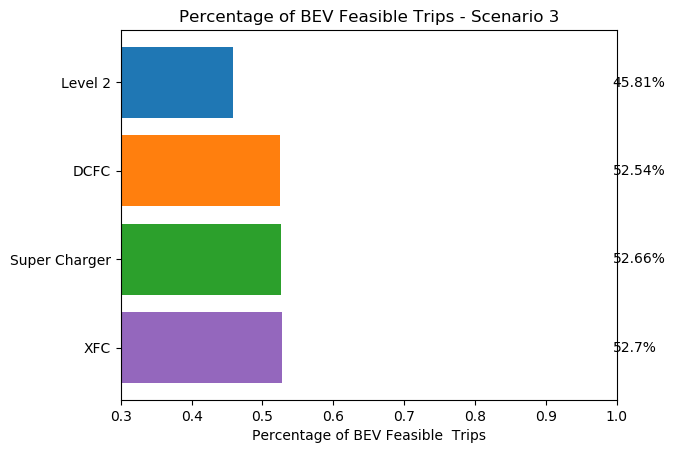

In [60]:
mile_left = 10
res['feasible1'] = (res['DIST2_Power1']>=res['MILES'] + mile_left)
res['feasible2'] = (res['DIST2_Power2']>=res['MILES'] + mile_left)
res['feasible3'] = (res['DIST2_Power3']>=res['MILES'] + mile_left)
res['feasible4'] = (res['DIST2_Power4']>=res['MILES'] + mile_left)

p = []
p.append(sum(res['feasible1'])/len(res['feasible1']))
p.append(sum(res['feasible2'])/len(res['feasible2']))
p.append(sum(res['feasible3'])/len(res['feasible3']))
p.append(sum(res['feasible4'])/len(res['feasible4']))

plt.rcdefaults()
fig, ax = plt.subplots()
label = ['Level 2','DCFC','Super Charger','XFC']
y_pos = np.arange(len(label))
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.barh(y_pos, p, align='center',color = ['#1f77b4','#ff7f0e','#2ca02c','#9467bd'])
ax.set_xlabel('Percentage of BEV Feasible  Trips')
plt.xlim((0.3, 1))
                                          
for group in range(0,len(p)):
    ax.text(0.994, group, str(round(p[group]*100,2))+'%', fontsize=10, verticalalignment="center")

ax.set_title('Percentage of BEV Feasible Trips - Scenario 3')

## Scenario 4. Charge publicly once per day and pick the one stop with the longest dwell time

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'Likelihood of Occurence')

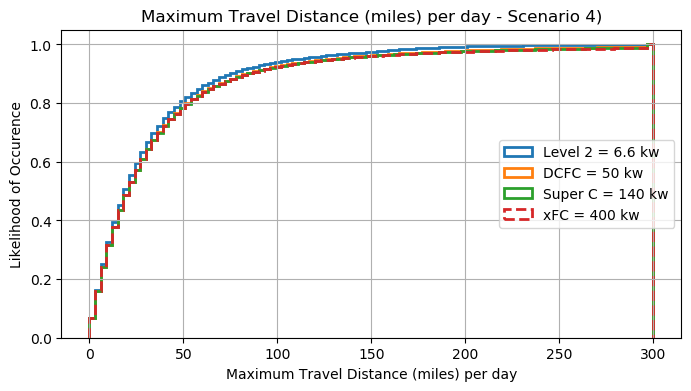

In [58]:
htemp = data['HOUSEID'][0] # each unique houseID
ptemp = data['PERSONID'][0]

data.VMT_MILE[data.VMT_MILE < 0] = 0

max_dt = 0 # max dwell time
miles_temp = 10 

dist_temp1 = 0
dist_temp2 = 0
dist_temp3 = 0
dist_temp4 = 0

res = pd.DataFrame(columns = ['H_ID', 'P_ID','DIST2_Power1','DIST2_Power2', 'DIST2_Power3','DIST2_Power4']) 
AER = 150

for n in range(len(data)):
    
    if data['HOUSEID'][n] == htemp and data['PERSONID'][n] == ptemp: # and 'H' in  data['TOURTYPE'][n]: # Home-based trips
        
        miles_temp += data['VMT_MILE'][n]
        # print (miles_temp)
        
        if data['DWELTIME'][n] > max_dt:
            index = n
            max_dt = data['DWELTIME'][n]
                   
    elif data['HOUSEID'][n] == htemp and data['PERSONID'][n] != ptemp: # and 'H' in  data['TOURTYPE'][n]:
        
        dist_temp1 = (min(data['DWELTIME'][index]/60 * Power1/ efficency, AER, miles_temp) )
        dist_temp2 = (min(data['DWELTIME'][index]/60 * Power2/ efficency, AER, miles_temp) )
        dist_temp3 = (min(data['DWELTIME'][index]/60 * Power3/ efficency, AER, miles_temp) )
        dist_temp4 = (min(data['DWELTIME'][index]/60 * Power4/ efficency, AER, miles_temp) )

        #res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'DIST2_Power1': min(AER,miles_temp) + dist_temp1, 'DIST2_Power2': min(AER,miles_temp)  + dist_temp2, 'DIST2_Power3': min(AER,miles_temp) + dist_temp3, 'DIST2_Power4': min(AER,miles_temp) + dist_temp4}, ignore_index=True) 
        res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'DIST2_Power1': AER + dist_temp1, 'DIST2_Power2': AER  + dist_temp2, 'DIST2_Power3': AER+ dist_temp3, 'DIST2_Power4': AER + dist_temp4}, ignore_index=True) 

        max_dt = 0
        ptemp = data['PERSONID'][n]
        miles_temp = data['VMT_MILE'][n]
        index = n
    
    elif data['HOUSEID'][n] != htemp: # and 'H' in  data['TOURTYPE'][n]:
        
        dist_temp1 = (min(data['DWELTIME'][index]/60 * Power1/ efficency, AER, miles_temp) )
        dist_temp2 = (min(data['DWELTIME'][index]/60 * Power2/ efficency, AER, miles_temp) )
        dist_temp3 = (min(data['DWELTIME'][index]/60 * Power3/ efficency, AER, miles_temp) )
        dist_temp4 = (min(data['DWELTIME'][index]/60 * Power4/ efficency, AER, miles_temp) )

        #res = res.append({'H_ID': htemp, 'P_ID': ptemp,'MILES': miles_temp, 'DIST2_Power1': min(AER,miles_temp)  + dist_temp1, 'DIST2_Power2': min(AER,miles_temp)  + dist_temp2, 'DIST2_Power3': min(AER,miles_temp)  + dist_temp3, 'DIST2_Power4': min(AER,miles_temp) + dist_temp4}, ignore_index=True) 
        res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'DIST2_Power1': AER + dist_temp1, 'DIST2_Power2': AER  + dist_temp2, 'DIST2_Power3': AER+ dist_temp3, 'DIST2_Power4': AER + dist_temp4}, ignore_index=True) 
        
        max_dt = 0
        htemp = data['HOUSEID'][n]
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]
        index = n
        
# res.to_pickle('results_feasibility/res_MaxDT.pkl')  
# res = pd.read_pickle('results_feasibility/res_MaxDist.pkl')
res['DIST2_Power1'] = res['DIST2_Power1']  + AER
res['DIST2_Power2'] = res['DIST2_Power2']  + AER
res['DIST2_Power3'] = res['DIST2_Power3']  + AER
res['DIST2_Power4'] = res['DIST2_Power4']  + AER

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(res['DIST2_Power1'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Level 2 = 6.6 kw')
ax.hist(res['DIST2_Power2'], 100, lw =2, density=True, histtype='step', cumulative=True, label='DCFC = 50 kw')
ax.hist(res['DIST2_Power3'], 100, lw =2, density=True, histtype='step',  cumulative=True, label='Super C = 140 kw')
ax.hist(res['DIST2_Power4'], 100, lw =2, density=True, histtype='step', linestyle=('dashed'), cumulative=True, label='xFC = 400 kw')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Travel Distance (miles) per day - Scenario 4)')
ax.set_xlabel('Maximum Travel Distance (miles) per day')
ax.set_ylabel('Likelihood of Occurence')

Text(0.5, 1.0, 'Percentage of BEV Feasible Trips - Scenario 4')

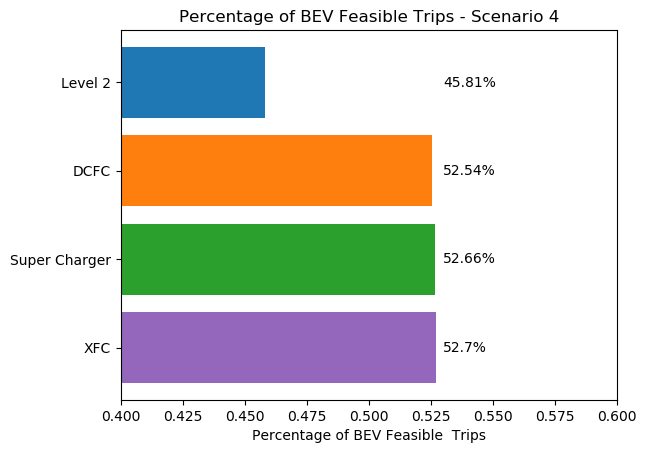

In [59]:
res['feasible1'] = (res['DIST2_Power1']>=res['MILES'] + mile_left)
res['feasible2'] = (res['DIST2_Power2']>=res['MILES'] + mile_left)
res['feasible3'] = (res['DIST2_Power3']>=res['MILES'] + mile_left)
res['feasible4'] = (res['DIST2_Power4']>=res['MILES'] + mile_left)

p = []
p.append(sum(res['feasible1'])/len(res['feasible1']))
p.append(sum(res['feasible2'])/len(res['feasible2']))
p.append(sum(res['feasible3'])/len(res['feasible3']))
p.append(sum(res['feasible4'])/len(res['feasible4']))

plt.rcdefaults()
fig, ax = plt.subplots()
label = ['Level 2','DCFC','Super Charger','XFC']
y_pos = np.arange(len(label))
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.barh(y_pos, p, align='center',color = ['#1f77b4','#ff7f0e','#2ca02c','#9467bd'])
ax.set_xlabel('Percentage of BEV Feasible  Trips')
plt.xlim((0.4,0.6))
                                          
for group in range(0,len(p)):
    ax.text(0.530, group, str(round(p[group]*100,2))+'%', fontsize=10, verticalalignment="center")

ax.set_title('Percentage of BEV Feasible Trips - Scenario 4')


## Changing the AER 

In [61]:
Power1 = 6.6 # KW
Power2 = 50
Power3 = 140
Power4 = 400

eu = [0.3, 0.305, 0.307, 0.329, 0.38, 0.385] # electric use kwh/mile
AER_all = [75,150,200,300]

efficency = eu[0] # kwh/mile
Chrg_capacity = 20 # kwh


htemp = data['HOUSEID'][0] # each unique houseID
ptemp = data['PERSONID'][0]
data.VMT_MILE[data.VMT_MILE < 0] = 0 # total miles traveled negative or less than 5 => 0
miles_temp = 0 # total miles


res = pd.DataFrame(columns = ['H_ID', 'P_ID','MILES','DIST2_Power1','DIST2_Power2', 'DIST2_Power3', 'DIST2_Power4']) 

results = []

for index, AER in enumerate(AER_all):
    
    print("AER: ", AER)
    dist_temp1 = AER
    dist_temp2 = AER
    dist_temp3 = AER
    dist_temp4 = AER

    for n in range(len(data)):
        
        if data['HOUSEID'][n] == htemp and data['PERSONID'][n] == ptemp: # and 'H' in  data['TOURTYPE'][n]: # Home-based trips
            
            miles_temp += data['VMT_MILE'][n]
            
            dist_temp1 += (min(data['DWELTIME'][n]/60 * Power1/ efficency, AER, miles_temp) - data['VMT_MILE'][n])
            dist_temp2 += (min(data['DWELTIME'][n]/60 * Power2/ efficency, AER, miles_temp) - data['VMT_MILE'][n])
            dist_temp3 += (min(data['DWELTIME'][n]/60 * Power3/ efficency, AER, miles_temp) - data['VMT_MILE'][n])
            dist_temp4 += (min(data['DWELTIME'][n]/60 * Power4/ efficency, AER, miles_temp) - data['VMT_MILE'][n])

        elif data['HOUSEID'][n] == htemp and data['PERSONID'][n] != ptemp: # and 'H' in  data['TOURTYPE'][n]:
            
            res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'DIST2_Power1': AER + miles_temp + dist_temp1, 'DIST2_Power2': AER + miles_temp + dist_temp2, 'DIST2_Power3': AER + miles_temp + dist_temp3, 'DIST2_Power4': AER + miles_temp + dist_temp4}, ignore_index=True) 
            
            ptemp = data['PERSONID'][n]
            
            miles_temp = data['VMT_MILE'][n]
            
            dist_temp1 = (min(data['DWELTIME'][n]/60 * Power1/ efficency, AER, miles_temp) - data['VMT_MILE'][n])
            dist_temp2 = (min(data['DWELTIME'][n]/60 * Power2/ efficency, AER, miles_temp) - data['VMT_MILE'][n])
            dist_temp3 = (min(data['DWELTIME'][n]/60 * Power3/ efficency, AER, miles_temp) - data['VMT_MILE'][n])
            dist_temp4 = (min(data['DWELTIME'][n]/60 * Power4/ efficency, AER, miles_temp) - data['VMT_MILE'][n])

            
        elif data['HOUSEID'][n] != htemp: # and 'H' in  data['TOURTYPE'][n]:
            
            res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'DIST2_Power1': AER + miles_temp + dist_temp1, 'DIST2_Power2': AER + miles_temp + dist_temp2, 'DIST2_Power3': AER + miles_temp + dist_temp3, 'DIST2_Power4': AER + miles_temp + dist_temp4}, ignore_index=True) 
            
            htemp = data['HOUSEID'][n]
            ptemp = data['PERSONID'][n]
            
            miles_temp = data['VMT_MILE'][n]
    
            dist_temp1 = (min(data['DWELTIME'][n]/60 * Power1/ efficency, AER, miles_temp) - data['VMT_MILE'][n])
            dist_temp2 = (min(data['DWELTIME'][n]/60 * Power2/ efficency, AER, miles_temp) - data['VMT_MILE'][n])
            dist_temp3 = (min(data['DWELTIME'][n]/60 * Power3/ efficency, AER, miles_temp) - data['VMT_MILE'][n])
            dist_temp4 = (min(data['DWELTIME'][n]/60 * Power4/ efficency, AER, miles_temp) - data['VMT_MILE'][n])

    results.append([res['MILES'],res['DIST2_Power1'],res['DIST2_Power2'], res['DIST2_Power3'],res['DIST2_Power4']])   
   
'''
# Save and load data   
with open("results_feasibility/Results_AER.txt", "wb") as fp:   #Pickling
    pickle.dump(results, fp)
    
with open("results_feasibility/Results_AER.txt", "rb") as fp:   # Unpickling
    results = pickle.load(fp)
'''

fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(AER_all)):
    ax.hist(results[i][0], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
    # ax.hist(results[i][1], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]))
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range - Charging power = 6.6 kw')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 4500))

fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(AER_all)):
    # ax.hist(results[i][0], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
    ax.hist(results[i][1], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range - Charging power = 50 kw')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 4500))


fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(AER_all)):
    # ax.hist(results[i][0], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
    ax.hist(results[i][2], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range - Charging power = 140 kw')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 4500))


fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(AER_all)):
    # ax.hist(results[i][0], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
    ax.hist(results[i][3], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range - Charging power = 400 kw')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 4500))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


AER:  75
AER:  150
AER:  200
AER:  300
AER:  400


KeyboardInterrupt: 

In [80]:
print(len(results[0]))

5


(0, 2500)

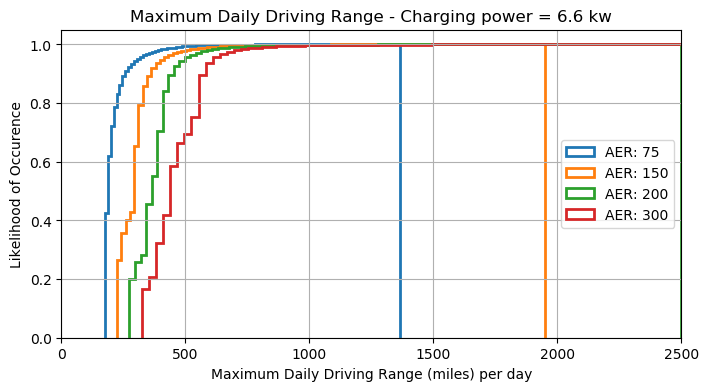

In [97]:
AER_all = [75,150,200,300]
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(AER_all)):
    ax.hist(results[i][4]+100+i*50, 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
    # ax.hist(results[i][1], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]))
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range - Charging power = 6.6 kw')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 2500))

(0, 3500)

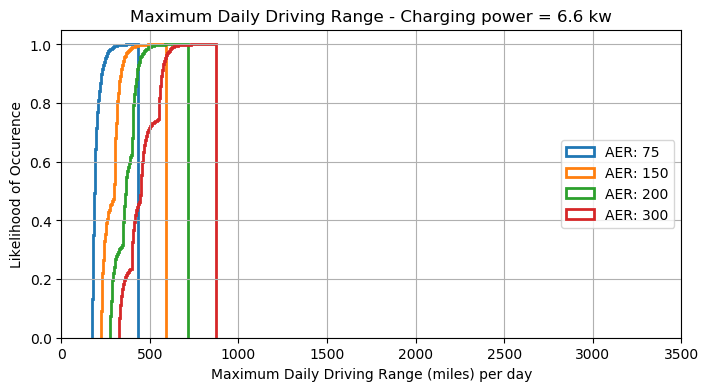

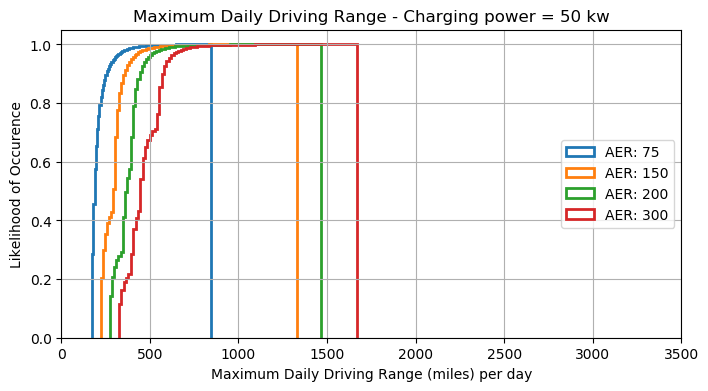

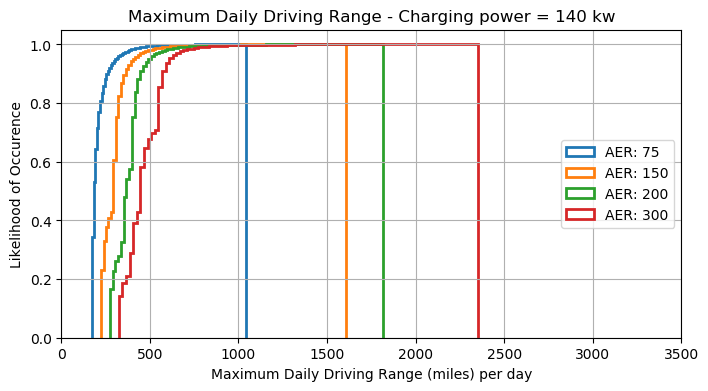

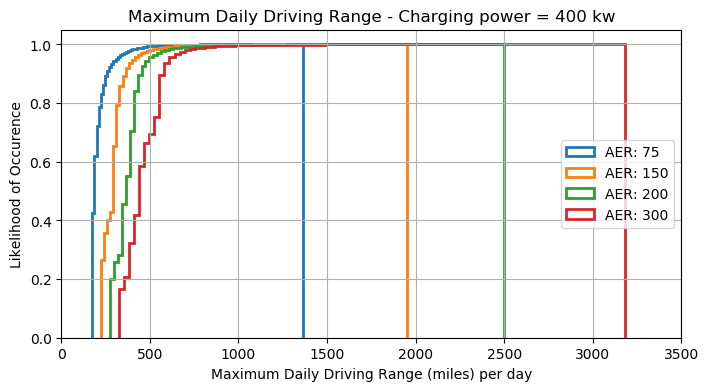

In [99]:
AER_all = [75,150,200,300]
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(AER_all)):
    ax.hist(results[i][1]+100+i*50, 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
    # ax.hist(results[i][1], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]))
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range - Charging power = 6.6 kw')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 3500))

fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(AER_all)):
    # ax.hist(results[i][0], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
    ax.hist(results[i][2]+100+i*50, 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range - Charging power = 50 kw')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 3500))


fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(AER_all)):
    # ax.hist(results[i][0], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
    ax.hist(results[i][3]+100+i*50, 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range - Charging power = 140 kw')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 3500))


fig, ax = plt.subplots(figsize=(8, 4))
for i in range(len(AER_all)):
    # ax.hist(results[i][0], 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
    ax.hist(results[i][4]+100+i*50, 100, lw =2, density=True, histtype='step', cumulative=True, label='AER: ' + str(AER_all[i]) )
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Daily Driving Range - Charging power = 400 kw')
ax.set_xlabel('Maximum Daily Driving Range (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 3500))

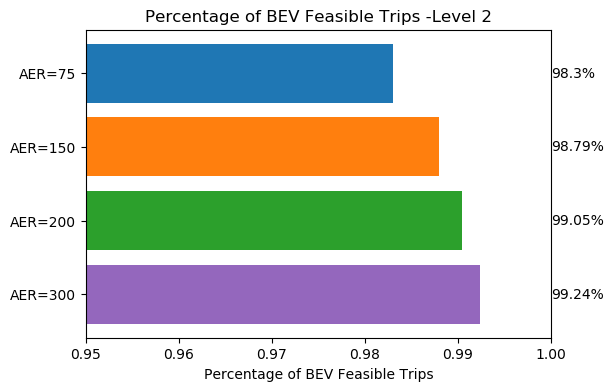

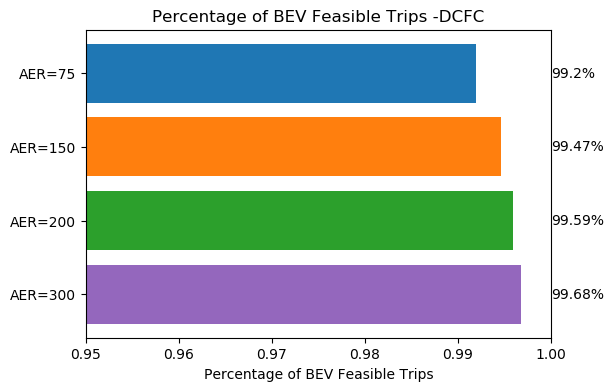

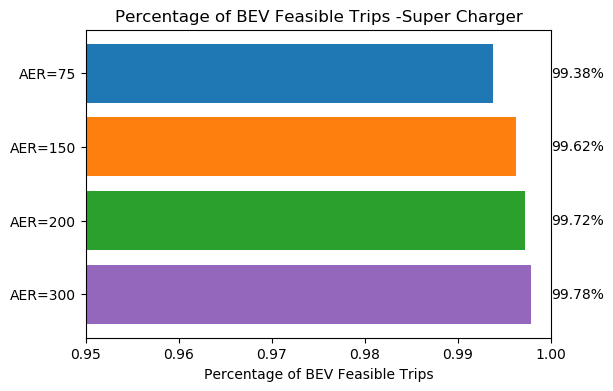

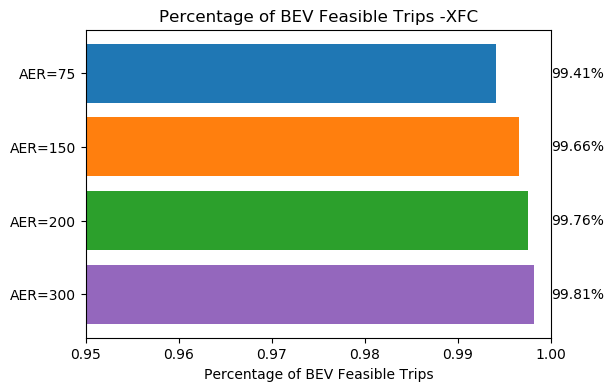

In [67]:
CP = ['Level 2', 'DCFC', 'Super Charger', 'XFC']
mile_left = 10

for c in range(1,5): # charger level, colume 0 : real travel distance "MILES"
    feasible = []
    p = []
    for r in range(4): # AER
        feasible.append(results[r][c]>=results[r][0] + mile_left)
        p.append(sum(feasible[r])/len(feasible[r]))

    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(6,4))
    label = ['AER=75','AER=150','AER=200', 'AER=300']
    y_pos = np.arange(len(label))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.barh(y_pos, p, align='center',color = ['#1f77b4','#ff7f0e','#2ca02c','#9467bd','#8c564b','#e377c2'])
    ax.set_xlabel('Percentage of BEV Feasible Trips')
    plt.xlim((0.95, 1))
    for group in range(0,len(p)):
        ax.text(1, group, str(round(p[group]*100,2))+'%', fontsize=10, verticalalignment="center")

    ax.set_title('Percentage of BEV Feasible Trips -'+str(CP[c-1]))
    
    plt.savefig('results_feasibility/ChrgPower'+ str(CP[c-1]), dpi=600)

## 4. Charging Oppotunities for scenario 1

In [ ]:
df = pd.read_pickle('trip_v3.pkl')
chgOp = 0.5 # charge opportunitie
chg_ind = np.random.binomial(1, chgOp, len(df)) # indicator variable: whether charge or not
df['chg'] = chg_ind

Power1 = 6.6 # KW
Power2 = 50
Power3 = 140
Power4 = 400

AER_all = [60,100,200,300,400,500] # mile
AER = 150

eu = [0.3, 0.305, 0.307, 0.329, 0.38, 0.385] # electric use kwh/mile
efficency = eu[0] # kwh/mile

Chrg_capacity = 20 # kwh

res = df
res['DIST_Power1'] = 0; res['DIST_Power2'] = 0; res['DIST_Power3'] = 0;

res['DIST_Power1'] = res['DWELTIME']/60 * Power1 / efficency *  res['chg']+ AER
res['DIST_Power2'] = res['DWELTIME']/60 * Power2 / efficency *  res['chg']+ AER
res['DIST_Power3'] = res['DWELTIME']/60 * Power3 / efficency *  res['chg']+ AER
res['DIST_Power4'] = res['DWELTIME']/60 * Power4 / efficency *  res['chg']+ AER

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(res['DIST_Power1'], 200, lw=2,density=True, histtype='step', cumulative=True, label='Level 2 = 6.6 kw')
ax.hist(res['DIST_Power2'], 200, lw=2,density=True, histtype='step', cumulative=True, label='DCFC = 50 kw')
ax.hist(res['DIST_Power3'], 200, lw=2,density=True, histtype='step', cumulative=True, label='Super C = 140 kw')
ax.hist(res['DIST_Power4'], 200, lw=2,density=True, histtype='step', cumulative=True, linestyle=('dashed'), label='xFC = 400 kw')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Travel Distance (miles) per day - Scenario 1, Charging Opportunity = 50%')
ax.set_xlabel('Maximum Travel Distance (miles) per day')
ax.set_ylabel('Likelihood of Occurence')


In [ ]:
mile_left = 10
res['feasible1'] = (res['DIST_Power1']>=res['VMT_MILE'] + mile_left)
res['feasible2'] = (res['DIST_Power2']>=res['VMT_MILE'] + mile_left)
res['feasible3'] = (res['DIST_Power3']>=res['VMT_MILE'] + mile_left)
res['feasible4'] = (res['DIST_Power4']>=res['VMT_MILE'] + mile_left)

p = []
p.append(sum(res['feasible1'])/len(res['feasible1']))
p.append(sum(res['feasible2'])/len(res['feasible2']))
p.append(sum(res['feasible3'])/len(res['feasible3']))
p.append(sum(res['feasible4'])/len(res['feasible4']))

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (6,4))
label = ['Level 2','DCFC','Super C','XFC']
y_pos = np.arange(len(label))
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.barh(y_pos, p, align='center',color = ['#1f77b4','#ff7f0e','#2ca02c','#9467bd'])
ax.set_xlabel('Percentage of BEV Feasible  Trips')
plt.xlim((0.995,1))
                                          
for group in range(0,len(p)):
    ax.text(0.999, group, str(round(p[group]*100,2))+'%', fontsize=10, verticalalignment="center")

ax.set_title('Scenario 1,Charging Opportunity=50%')

## Charging Oppotunities for scenario 2

In [ ]:
chg_ind = np.random.binomial(1, chgOp, len(df)) # indicator variable: whether charge or not
data['chg'] = chg_ind

htemp = data['HOUSEID'][0] # each unique houseID
ptemp = data['PERSONID'][0]

AER = 150
miles_temp = 0 # total miles
dw_temp = 0 # dwell time
tt_temp = 0 # travel time
dist_temp1 = AER
dist_temp2 = AER
dist_temp3 = AER
dist_temp4 = AER

Chrg_capacity = 20 # kwh

res = pd.DataFrame(columns = ['H_ID', 'P_ID','MILES','TIMES','DWT','Weight','DIST2_Power1','DIST2_Power2','DIST2_Power3','DIST2_Power4']) 
for n in range(len(data)):
    
    if data['HOUSEID'][n] == htemp and data['PERSONID'][n] == ptemp: # same household ID, same persion ID
        
        miles_temp += data['VMT_MILE'][n]
        dw_temp += data['DWELTIME'][n]
        tt_temp += data['TRVLCMIN'][n]
        
        dist_temp1 += min(data['DWELTIME'][n]/60 * Power1 * data['chg'][n], Chrg_capacity) / efficency
        dist_temp2 += min(data['DWELTIME'][n]/60 * Power2 * data['chg'][n], Chrg_capacity) / efficency
        dist_temp3 += min(data['DWELTIME'][n]/60 * Power3 * data['chg'][n], Chrg_capacity) / efficency
        dist_temp4 += min(data['DWELTIME'][n]/60 * Power4 * data['chg'][n], Chrg_capacity) / efficency

        
    elif data['HOUSEID'][n] == htemp and data['PERSONID'][n] != ptemp: # Same HH id, diff persion ID
        
        res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'TIMES': tt_temp, 'DWT': dw_temp,'Weight':data['WTTRDFIN'][n],'DIST2_Power1': dist_temp1, 'DIST2_Power2': dist_temp2, 'DIST2_Power3': dist_temp3, 'DIST2_Power4': dist_temp4}, ignore_index=True) 
        
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]
        dw_temp = data['DWELTIME'][n] 
        tt_temp = data['TRVLCMIN'][n]
        
        dist_temp1 = min(data['DWELTIME'][n]/60 * Power1 * data['chg'][n], Chrg_capacity) / efficency + AER
        dist_temp2 = min(data['DWELTIME'][n]/60 * Power2 * data['chg'][n], Chrg_capacity) / efficency + AER
        dist_temp3 = min(data['DWELTIME'][n]/60 * Power3 * data['chg'][n], Chrg_capacity) / efficency + AER
        dist_temp4 = min(data['DWELTIME'][n]/60 * Power4 * data['chg'][n], Chrg_capacity) / efficency + AER

    elif data['HOUSEID'][n] != htemp: # diff HH ID
        
        res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'TIMES': tt_temp, 'DWT': dw_temp,'Weight':data['WTTRDFIN'][n],'DIST2_Power1': dist_temp1, 'DIST2_Power2': dist_temp2, 'DIST2_Power3': dist_temp3, 'DIST2_Power4': dist_temp4}, ignore_index=True) 
        
        htemp = data['HOUSEID'][n]
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]
        dw_temp = data['DWELTIME'][n]
        tt_temp = data['TRVLCMIN'][n]

        dist_temp1 = min(data['DWELTIME'][n]/60 * Power1 * data['chg'][n], Chrg_capacity) / efficency + AER
        dist_temp2 = min(data['DWELTIME'][n]/60 * Power2 * data['chg'][n], Chrg_capacity) / efficency + AER
        dist_temp3 = min(data['DWELTIME'][n]/60 * Power3 * data['chg'][n], Chrg_capacity) / efficency + AER
        dist_temp4 = min(data['DWELTIME'][n]/60 * Power4 * data['chg'][n], Chrg_capacity) / efficency + AER

# res.to_pickle('results_feasibility/res_scenario2_Opp.pkl')  
# res = pd.read_pickle('results_feasibility/res_scenario2_Opp.pkl')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(res['DIST2_Power1'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Level 2 = 6.6 kw')
ax.hist(res['DIST2_Power2'], 100, lw =2, density=True, histtype='step', cumulative=True, label='DCFC = 50 kw')
ax.hist(res['DIST2_Power3'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Super C = 140 kw')
ax.hist(res['DIST2_Power4'], 100, lw =2, density=True, histtype='step',linestyle=('dashed'), cumulative=True, label='xFC = 400 kw')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Travel Distance (miles) per day - scenario 2, Charging Opportunitiy = 50%')
ax.set_xlabel('Maximum Travel Distance (miles) per day')
ax.set_ylabel('Likelihood of Occurence')

In [ ]:
mile_left = 10
res['feasible1'] = (res['DIST2_Power1']>=res['MILES'] + mile_left)
res['feasible2'] = (res['DIST2_Power2']>=res['MILES'] + mile_left)
res['feasible3'] = (res['DIST2_Power3']>=res['MILES'] + mile_left)
res['feasible4'] = (res['DIST2_Power4']>=res['MILES'] + mile_left)

p = []
p.append(sum(res['feasible1'])/len(res['feasible1']))
p.append(sum(res['feasible2'])/len(res['feasible2']))
p.append(sum(res['feasible3'])/len(res['feasible3']))
p.append(sum(res['feasible4'])/len(res['feasible4']))

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (6,4))
label = ['Level 2','DCFC','Super C','XFC']
y_pos = np.arange(len(label))
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.barh(y_pos, p, align='center',color = ['#1f77b4','#ff7f0e','#2ca02c','#9467bd'])
ax.set_xlabel('Percentage of BEV Feasible  Trips')
plt.xlim((0.985,1))
                                          
for group in range(0,len(p)):
    ax.text(0.995, group, str(round(p[group]*100,2))+'%', fontsize=10, verticalalignment="center")

ax.set_title('Scenario 2,Charging Opportunity=50%')

## 4. Charging Oppotunities for scenario 3 

In [ ]:
chgOp = 0.8 # charge opportunitie
chg_ind = np.random.binomial(1, chgOp, len(df)) # indicator variable: whether charge or not
data['chg'] = chg_ind

htemp = data['HOUSEID'][0] # each unique houseID
ptemp = data['PERSONID'][0]

data.VMT_MILE[data.VMT_MILE < 0] = 0 # total miles traveled negative or less than 5 => 0

AER = 150
miles_temp = 0 # total miles
dist_temp1 = 0
dist_temp2 = 0
dist_temp3 = 0
dist_temp4 = 0

res = pd.DataFrame(columns = ['H_ID', 'P_ID','MILES','DIST2_Power1','DIST2_Power2', 'DIST2_Power3','DIST2_Power4']) 
AER = 60

for n in range(len(data)):
    
    if data['HOUSEID'][n] == htemp and data['PERSONID'][n] == ptemp: # and 'H' in  data['TOURTYPE'][n]: # Home-based trips
        
        miles_temp += data['VMT_MILE'][n]
        
        dist_temp1 += (min(data['DWELTIME'][n]/60 * Power1/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp2 += (min(data['DWELTIME'][n]/60 * Power2/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp3 += (min(data['DWELTIME'][n]/60 * Power3/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp4 += (min(data['DWELTIME'][n]/60 * Power4/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])

    elif data['HOUSEID'][n] == htemp and data['PERSONID'][n] != ptemp: # and 'H' in  data['TOURTYPE'][n]:
        
        res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'DIST2_Power1': AER + miles_temp + dist_temp1, 'DIST2_Power2': AER + miles_temp + dist_temp2, 'DIST2_Power3': AER + miles_temp + dist_temp3, 'DIST2_Power4': AER + miles_temp + dist_temp4}, ignore_index=True) 
        
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]
        
        dist_temp1 = (min(data['DWELTIME'][n]/60 * Power1/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp2 = (min(data['DWELTIME'][n]/60 * Power2/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp3 = (min(data['DWELTIME'][n]/60 * Power3/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp4 = (min(data['DWELTIME'][n]/60 * Power4/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])
        
        
    elif data['HOUSEID'][n] != htemp: # and 'H' in  data['TOURTYPE'][n]:
        
        res = res.append({'H_ID': htemp, 'P_ID': ptemp, 'MILES': miles_temp, 'DIST2_Power1': AER + miles_temp + dist_temp1, 'DIST2_Power2': AER + miles_temp + dist_temp2, 'DIST2_Power3': AER + miles_temp + dist_temp3, 'DIST2_Power4': AER + miles_temp + dist_temp4}, ignore_index=True) 
        
        htemp = data['HOUSEID'][n]
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]

        dist_temp1 = (min(data['DWELTIME'][n]/60 * Power1/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp2 = (min(data['DWELTIME'][n]/60 * Power2/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp3 = (min(data['DWELTIME'][n]/60 * Power3/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp4 = (min(data['DWELTIME'][n]/60 * Power4/ efficency * data['chg'][n], AER, miles_temp) - data['VMT_MILE'][n])

# res.to_pickle('results_feasibility/res_scenario3_opp_'+str(chgOp)+'.pkl')  
# res = pd.read_pickle('results_feasibility/res_scenario3_opp_'+str(chgOp)+'.pkl')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(res['DIST2_Power1'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Level 2 = 6.6 kw')
ax.hist(res['DIST2_Power2'], 100, lw =2, density=True, histtype='step', cumulative=True, label='DCFC = 50 kw')
ax.hist(res['DIST2_Power3'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Super C = 140 kw')
ax.hist(res['DIST2_Power4'], 100, lw =2, density=True, histtype='step', linestyle=('dashed'), cumulative=True, label='xFC= 400 kw')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Travel Distance (miles) per day - scenario 3, Charging Opportunity = 10%')
ax.set_xlabel('Maximum Travel Distance (miles) per day')
ax.set_ylabel('Likelihood of Occurence')
plt.xlim((0, 1000))

In [ ]:
## PLOT feasibility ##
mile_left = 10
res['feasible1'] = (res['DIST2_Power1']>=res['MILES'] + mile_left)
res['feasible2'] = (res['DIST2_Power2']>=res['MILES'] + mile_left)
res['feasible3'] = (res['DIST2_Power3']>=res['MILES'] + mile_left)
res['feasible4'] = (res['DIST2_Power4']>=res['MILES'] + mile_left)

p = []
p.append(sum(res['feasible1'])/len(res['feasible1']))
p.append(sum(res['feasible2'])/len(res['feasible2']))
p.append(sum(res['feasible3'])/len(res['feasible3']))
p.append(sum(res['feasible4'])/len(res['feasible4']))

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (6,4))
label = ['Level 2','DCFC','Super C','XFC']
y_pos = np.arange(len(label))
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.barh(y_pos, p, align='center',color = ['#1f77b4','#ff7f0e','#2ca02c','#9467bd'])
ax.set_xlabel('Percentage of BEV Feasible Trips')
plt.xlim((0.9,0.995))
                                          
for group in range(0,len(p)):
    ax.text(0.986, group, str(round(p[group]*100,2))+'%', fontsize=10, verticalalignment="center")

ax.set_title('Scenario 3,Charging Opportunity='+str(int(chgOp*100))+'%')

## Charging at home for scenario 3

In [ ]:
htemp = data['HOUSEID'][0] # each unique houseID
ptemp = data['PERSONID'][0]

data.VMT_MILE[data.VMT_MILE < 0] = 0 # total miles traveled negative or less than 5 => 0

AER = 150

miles_temp = 0 # total miles
mile_left = 10

dist_temp1 = 0
dist_temp2 = 0
dist_temp3 = 0
dist_temp4 = 0

home_charge = 1  # percentage of EV owner will charge at home
SOC_home = 0.2 # initial soc from home

f_temp = 1 # feasibility for each trip
chg_home= np.random.binomial(1, home_charge, 1)[0] # if charge at home fully
soc_temp1 = max(SOC_home,chg_home) * AER # allowable driving range
soc_temp2 = soc_temp1; soc_temp3 = soc_temp1; soc_temp4=soc_temp1
f_temp1 = 1; f_temp2 = 1; f_temp3 = 1; f_temp4 = 1; 


res = pd.DataFrame(columns = ['H_ID', 'P_ID','MILES','DIST2_Power1','DIST2_Power2', 'DIST2_Power3','DIST2_Power4','feasible1','feasible2','feasible3','feasible4']) 

for n in range(len(data)):# len(data)
        
    if data['HOUSEID'][n] == htemp and data['PERSONID'][n] == ptemp: # and 'H' in  data['TOURTYPE'][n]: # Home-based trips
            
        miles_temp += data['VMT_MILE'][n]
        
        dist_temp1 += (min(data['DWELTIME'][n]/60 * Power1/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp2 += (min(data['DWELTIME'][n]/60 * Power2/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp3 += (min(data['DWELTIME'][n]/60 * Power3/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp4 += (min(data['DWELTIME'][n]/60 * Power4/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        
        # feasibility:
        soc_temp1 -= data['VMT_MILE'][n] 
        if soc_temp1 < data['VMT_MILE'][n] + mile_left:
            f_temp1 = 0
            
        soc_temp2 -= data['VMT_MILE'][n] 
        if soc_temp2 < data['VMT_MILE'][n] + mile_left:
            f_temp2 = 0
            
        soc_temp3 -= data['VMT_MILE'][n] 
        if soc_temp3 < data['VMT_MILE'][n] + mile_left:
            f_temp3 = 0
            
        soc_temp4 -= data['VMT_MILE'][n] 
        if soc_temp4 < data['VMT_MILE'][n] + mile_left:
            f_temp4 = 0
        
        soc_temp1 += data['DWELTIME'][n]/60 * Power1/ efficency
        soc_temp2 += data['DWELTIME'][n]/60 * Power2/ efficency
        soc_temp3 += data['DWELTIME'][n]/60 * Power3/ efficency
        soc_temp4 += data['DWELTIME'][n]/60 * Power4/ efficency

    elif data['HOUSEID'][n] == htemp and data['PERSONID'][n] != ptemp: # and 'H' in  data['TOURTYPE'][n]:
        
        res = res.append({'H_ID': htemp, 'P_ID': ptemp,'MILES':miles_temp, 
                          'DIST2_Power1': max(chg_home,SOC_home) * AER + miles_temp + dist_temp1, 
                          'DIST2_Power2': max(chg_home,SOC_home) * AER + miles_temp + dist_temp2, 
                          'DIST2_Power3': max(chg_home,SOC_home) * AER + miles_temp + dist_temp3, 
                          'DIST2_Power4': max(chg_home,SOC_home) * AER + miles_temp + dist_temp4,
                          'feasible1':f_temp1,
                          'feasible2':f_temp2,
                          'feasible3':f_temp3,
                          'feasible4':f_temp4}, ignore_index=True) 
        
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]
        
        dist_temp1 = (min(data['DWELTIME'][n]/60 * Power1/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp2 = (min(data['DWELTIME'][n]/60 * Power2/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp3 = (min(data['DWELTIME'][n]/60 * Power3/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp4 = (min(data['DWELTIME'][n]/60 * Power4/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        
        chg_home= np.random.binomial(1, home_charge, 1)[0] # if charge at home fully
        soc_temp1 = max(SOC_home,chg_home) * AER; soc_temp2 = soc_temp1; soc_temp3 = soc_temp1; soc_temp4 = soc_temp1;
        
        f_temp1 = 1; f_temp2 =1; f_temp3=1; f_temp4=1
        
    elif data['HOUSEID'][n] != htemp: # and 'H' in  data['TOURTYPE'][n]:
        
        res = res.append({'H_ID': htemp, 'P_ID': ptemp,'MILES':miles_temp,
                          'DIST2_Power1': max(chg_home,SOC_home) * AER + miles_temp + dist_temp1, 
                          'DIST2_Power2': max(chg_home,SOC_home) * AER + miles_temp + dist_temp2, 
                          'DIST2_Power3': max(chg_home,SOC_home) * AER + miles_temp + dist_temp3, 
                          'DIST2_Power4': max(chg_home,SOC_home) * AER + miles_temp + dist_temp4,
                          'feasible1':f_temp1,
                          'feasible2':f_temp2,
                          'feasible3':f_temp3,
                          'feasible4':f_temp4}, ignore_index=True) 
        
        htemp = data['HOUSEID'][n]
        ptemp = data['PERSONID'][n]
        
        miles_temp = data['VMT_MILE'][n]

        dist_temp1 = (min(data['DWELTIME'][n]/60 * Power1/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp2 = (min(data['DWELTIME'][n]/60 * Power2/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp3 = (min(data['DWELTIME'][n]/60 * Power3/ efficency , AER, miles_temp) - data['VMT_MILE'][n])
        dist_temp4 = (min(data['DWELTIME'][n]/60 * Power4/ efficency , AER, miles_temp) - data['VMT_MILE'][n])

        chg_home= np.random.binomial(1, home_charge, 1)[0] # if charge at home fully
        soc_temp1 = max(SOC_home,chg_home) * AER; soc_temp2 = soc_temp1; soc_temp3 = soc_temp1; soc_temp4 = soc_temp1;

        f_temp1 = 1; f_temp2 =1; f_temp3=1; f_temp4=1

# res.to_pickle('results_feasibility/res_scenario3_home_'+str(home_charge)+'.pkl')  
# res = pd.read_pickle('results_feasibility/res_scenario3_home_'+str(home_charge)+'.pkl')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(res['DIST2_Power1'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Level 2 = 6.6 kw')
ax.hist(res['DIST2_Power2'], 100, lw =2, density=True, histtype='step', cumulative=True, label='DCFC= 50 kw')
ax.hist(res['DIST2_Power3'], 100, lw =2, density=True, histtype='step', cumulative=True, label='Super C = 140 kw')
ax.hist(res['DIST2_Power4'], 100, lw =2, density=True, histtype='step', linestyle=('dashed'), cumulative=True, label='xFC= 400 kw')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Maximum Travel Distance (miles) per day considering residential charging')
ax.set_xlabel('Maximum Travel Distance (miles) per day')
ax.set_ylabel('Likelihood of Occurence')


In [ ]:
## PLOT feasibility ##
p = []
p.append(sum(res['feasible1'])/len(res['feasible1']))
p.append(sum(res['feasible2'])/len(res['feasible2']))
p.append(sum(res['feasible3'])/len(res['feasible3']))
p.append(sum(res['feasible4'])/len(res['feasible4']))

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (6,4))
label = ['Level 2','DCFC','Super C','XFC']
y_pos = np.arange(len(label))
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.barh(y_pos, p, align='center',color = ['#1f77b4','#ff7f0e','#2ca02c','#9467bd'])
ax.set_xlabel('Percentage of BEV Feasible Trips')
plt.xlim((0.85,0.995))
                                          
for group in range(0,len(p)):
    ax.text(1, group, str(round(p[group]*100,2))+'%', fontsize=10, verticalalignment="center")

ax.set_title('Sc35enario 3,Residential Charging Opportunity='+str(int(home_charge*100))+'%')